# IMAGE COMPRESSION USING DCT
1. Apply DCT (Discrete Cosine Transform on an image)
2. Reconstruct the image by taking inverse DCT (IDCT)
3. Perform DCT based quantization on given 8 * 8 Matrix

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct

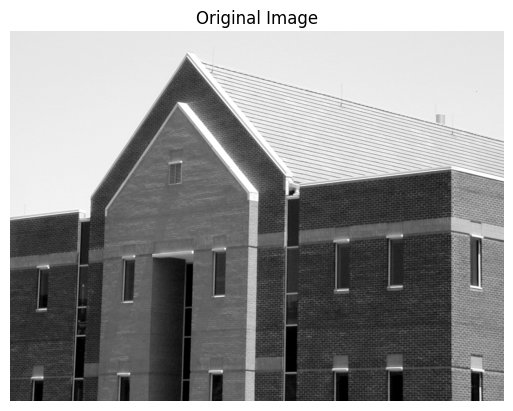

In [2]:
img = cv2.imread("Images\Edge detectn.bmp",cv2.IMREAD_GRAYSCALE)
plt.title("Original Image")
plt.axis("off")
plt.imshow(img,cmap = 'gray')
plt.show()

# Algorithm:
1. Start.
2. Take 8X8 Matrix.
3. Leveled off the matrix by subtracting 128 from each entry. (Matrix M)
4. Obtain DCT of above matrix by using the 2D DCT formula. (Matrix D)
  * Obtain the coefficient matrix by using formula (Matrix T).
  * Obtain DCT Matrix, D = TMT’.
5. Select Quantization level, and initialize standard Q matrix. (Matrix Q)
6. Obtain Quantization by dividing each element in the transformed image matrix D by the corresponding element in the Q matrix. And rounding off to the nearest integer value. (This is quantized matrix can be further coded). C (i,j) = round( D(i,j) / Q(i,j));
7. For Decompression, R(i, j) = Q(I, j) x C(i, j)
8. Obtain the IDCT of above matrix, and round off it to the nearest integer value.
9. Add 128 to each element.
10. Compare original and recover image.
(Note: If the M x N size image has to be compressed, divide the image into 8x8 blocks and repeat the above procedure for each block.)

In [3]:
# def alpha(p,N = 8):
#     """Normalization factor for DCT."""
#     return np.sqrt(1 / N) if p == 0 else np.sqrt(2 / N)
# def DCT(block):
#     """
#     Compute the 2D DCT of an NxN block using the direct formula.
#     block: 2D NumPy array of shape (N, N).
#     Returns D, the DCT coefficients array of same shape.
#     """
#     block = np.asarray(block,dtype = np.float32)
#     N, M = block.shape
#     if N != M:
#         raise ValueError("Block must be square NxN")
#     D = np.zeros((N, N), dtype=np.float32)
#     for u in range(N):
#         for v in range(N):
#             res = 0.0
#             for x in range(N):
#                 for y in range(N):
#                     pixel = block[x,y]
#                     # compute horizontal basis at x for frequency u
#                     basis_x = np.cos((2*x + 1) * u * np.pi / (2 * N))
#                     # compute vertical basis at y for frequency v
#                     basis_y = np.cos((2*y + 1) * v * np.pi / (2 * N))
#                     # accumulate weighted pixel value
#                     res += pixel * basis_x * basis_y
#             D[u,v] = res * alpha(u,N) * alpha(v,N)
#     return D

"""Or use this inbuilt function for faster processing"""
def dct2D(block):
    return dct(dct(block.T,norm='ortho').T,norm = 'ortho')

In [4]:
# def IDCT(D):
#     """
#     Compute the 2D inverse DCT of an NxN coefficient matrix using the direct formula.
#     D: 2D NumPy array of DCT coefficients shape (N, N).
#     Returns block, the reconstructed image block.
#     Inverse process:
#       - Reconstruct each pixel (x,y) by summing over all frequencies (u,v):
#           alpha(u)*alpha(v)*D[u,v]*basis_u(x)*basis_v(y)
#     """
#     D = np.asarray(D, dtype=float)
#     N, M = D.shape
#     if N != M:
#         raise ValueError("Coefficient matrix must be square NxN")
#     block = np.zeros((N, N), dtype=float)

#     # Loop over spatial positions x and y
#     for x in range(N):
#         for y in range(N):
#             sum_val = 0.0
#             # Sum contributions from each frequency component
#             for u in range(N):
#                 for v in range(N):
#                     coeff = D[u, v]
#                     # normalization factors
#                     norm = alpha(u, N) * alpha(v, N)
#                     # basis evaluations
#                     basis_x = np.cos((2*x + 1) * u * np.pi / (2 * N))
#                     basis_y = np.cos((2*y + 1) * v * np.pi / (2 * N))
#                     sum_val += norm * coeff * basis_x * basis_y
#             block[x, y] = sum_val
#     return block

"""Or use this inbuilt function for faster processing"""
def idct2D(block):
    return idct(idct(block.T,norm='ortho').T,norm = 'ortho')

In [7]:
def pad_image(img, block_size=8):
    """Pad to multiple of block_size."""
    h, w = img.shape
    pad_h = (block_size - h % block_size) % block_size
    pad_w = (block_size - w % block_size) % block_size
    return np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

In [5]:
def compress_image(img_arr, Q):
    """Compress and decompress an image array using DCT and IDCT functions."""
    padded = pad_image(img_arr, 8)
    h, w = padded.shape
    DCT_img = np.zeros_like(padded, dtype=float)
    quant_img = np.zeros_like(padded, dtype=float)
    recon = np.zeros_like(padded, dtype=float)

    for i in range(0, h, 8): # 8 is the block size
        for j in range(0, w, 8):
            block = padded[i:i+8, j:j+8].astype(float)
            # 1. Level shift
            M = block - 128.0
            # 2. DCT
            D = dct2D(M)
            # 3. Quantize
            C = np.round(D / Q)
            # 4. Dequantize
            R = C * Q
            # 5. IDCT
            M_recon = idct2D(R)
            # 6. Reverse level shift
            recon_block = M_recon + 128.0

            DCT_img[i:i+8, j:j+8] = D
            quant_img[i:i+8, j:j+8] = R
            recon[i:i+8, j:j+8] = recon_block

    # crop and clip
    orig_h, orig_w = img_arr.shape
    recon = recon[:orig_h, :orig_w]
    DCT_img = DCT_img[:orig_h, :orig_w]
    quant_img = quant_img[:orig_h, :orig_w]
    return DCT_img, quant_img, np.clip(recon, 0, 255).astype(np.uint8)

In [10]:
# Jpeg Standard Quantization Matrix
Q50 = np.array([
        [16,11,10,16,24,40,51,61],
        [12,12,14,19,26,58,60,55],
        [14,13,16,24,40,57,69,56],
        [14,17,22,29,51,87,80,62],
        [18,22,37,56,68,109,103,77],
        [24,35,55,64,81,104,113,92],
        [49,64,78,87,103,121,120,101],
        [72,92,95,98,112,100,103,99]
    ], dtype=float)  # Q90 = Q50 * 1.5 , Q10 = Q50 * 0.1
DCT_Q50,IDCT_Q50,rec = compress_image(img,Q50)

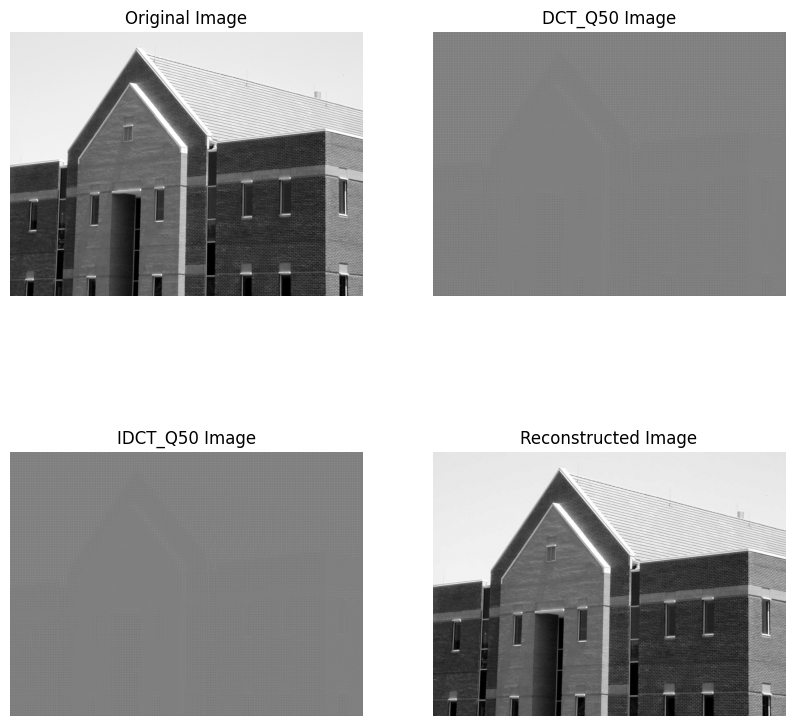

In [11]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(img,cmap = 'gray')

plt.subplot(2,2,2)
plt.title("DCT_Q50 Image")
plt.axis("off")
plt.imshow(DCT_Q50,cmap = 'gray')

plt.subplot(2,2,3)
plt.title("IDCT_Q50 Image")
plt.axis("off")
plt.imshow(IDCT_Q50,cmap = 'gray')

plt.subplot(2,2,4)
plt.title("Reconstructed Image")
plt.axis("off")
plt.imshow(rec,cmap = 'gray')

plt.show()